## Starting Makemore!

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [2]:

words = open('./names.txt','r').read().splitlines()
all_chars = []
for w in words:
    all_chars += list(set(w))


#Alternative
# sorted(list(set(''.join(words)))) #alphabetical listing of all characters in the words
all_chars = list(set(all_chars))

stoi = {char:num for char, num in zip(sorted(all_chars), range(1, len(all_chars)+1))}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}

In [3]:
##Exercise 1:
"""
01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. 
Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?
"""

#Create bigram training set
xs = []
ys = []

for w in words:
    chs = ['.'] + list(w) + ['.'] #adding start and end token to the word character
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        #print(f'Ch1: ', ch1)
        #print(f'Ch2: ', ch2)
        #print(f'Ch3: ', ch3)
        ix1 = stoi.get(ch1, 'ix1 missing')
        ix2 = stoi.get(ch2, 'ix2 missing')
        ix3 = stoi.get(ch3, 'ix3 missing')

        #print('-----')
        xs.append((ix1, ix2))
        ys.append(ix3)


xs = torch.tensor(xs)
ys = torch.tensor(ys)

#Create num variable for getting probability distribution. Th
num = xs.shape[0] #Changing this to properly count the number of samples we're using

print('Number of examples: ', num)
print('Xs shape ', xs.shape)

Number of examples:  196113
Xs shape  torch.Size([196113, 2])


### Concatenating embeddings approach
- since we are now predicting off of a bigram input we need to adjust our one hot encoding. If we don't we won't be able to calculate the logits from the 
xenc@W operation. 
- One method to do this is by concatenating the one-hot encodings of the characters in the bigram. This preserves information from the encoding itself AND provides additional positional information. 

In [4]:
#Now we will work on one hot encoding the xs variables
#For one hot encoding 
#2*len(stoi.keys() -> represents the dimension of the concatenated bigram
g = torch.Generator().manual_seed(2147488364)
W = torch.randn((2*len(stoi.keys()), 27), generator = g, requires_grad = True) #make sure that requires_grad is on!
xenc = F.one_hot(xs,  num_classes = len(stoi.keys())).float().reshape(num, -1)
print('bigram shape: ', xs.shape)
print('Encoding shape: ', xenc.shape)
print("W shape: ", W.shape)

assert xenc.shape[1] == W.shape[0]#This assert 
xenc[0]


bigram shape:  torch.Size([196113, 2])
Encoding shape:  torch.Size([196113, 54])
W shape:  torch.Size([54, 27])


tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
(xenc@W).shape

torch.Size([196113, 27])

In [6]:
loss_storage = []
for iter in range(100):

    #Now we have the probablities that each word is selected. 
    logits = (xenc@W) #This calculates neural network output

    #needs to transform logits to positive and then scale 
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims = True) #double check that we keep keepdims = True!

    loss = -probs[torch.arange(num), ys].log().mean()

    #Regularization attempt
    loss += 0.01 * (W**2).mean()

    W.grad = None#reset the gradient for the weght matrix
    loss.backward() #do back propagation

    print(f"Loss kth-iter {iter + 1}: ", loss.item())
    loss_storage.append(loss.item())

    W.data += -5 * W.grad #we want to use a negative value here as we continue to minimize the loss

Loss kth-iter 1:  4.4137163162231445
Loss kth-iter 2:  4.305039882659912
Loss kth-iter 3:  4.202096462249756
Loss kth-iter 4:  4.104547500610352
Loss kth-iter 5:  4.012162208557129
Loss kth-iter 6:  3.9247820377349854
Loss kth-iter 7:  3.8423073291778564
Loss kth-iter 8:  3.7646777629852295
Loss kth-iter 9:  3.6918578147888184
Loss kth-iter 10:  3.6238186359405518
Loss kth-iter 11:  3.5605199337005615
Loss kth-iter 12:  3.50189471244812
Loss kth-iter 13:  3.4478256702423096
Loss kth-iter 14:  3.398139238357544
Loss kth-iter 15:  3.3525946140289307
Loss kth-iter 16:  3.310896396636963
Loss kth-iter 17:  3.272705078125
Loss kth-iter 18:  3.237658977508545
Loss kth-iter 19:  3.205396890640259
Loss kth-iter 20:  3.17557430267334
Loss kth-iter 21:  3.1478793621063232
Loss kth-iter 22:  3.122037649154663
Loss kth-iter 23:  3.0978140830993652
Loss kth-iter 24:  3.0750131607055664
Loss kth-iter 25:  3.053471088409424
Loss kth-iter 26:  3.0330543518066406
Loss kth-iter 27:  3.0136518478393555
L

In [7]:
num

196113

In [8]:
for i in range(0,10):
    out = []
    ix1 = 0
    ix2 = 0
    ix = [ix1, ix2]

    
    
    print("------")
    print("Input tensor: ", ix)
    
    print("reshape Encoding shape", xenc.shape)
    print("reshape Encoding, ", xenc)

    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=len(stoi.keys())).float().reshape(1, -1)
        logits = (xenc@W)
        counts = logits.exp()
        probs = counts/counts.sum(1, keepdims = True)

        pred_int = torch.multinomial(probs, num_samples = 1, replacement = True, generator=g).item()
        ix1 = ix2
        ix2 = pred_int
        
        ix = ix[1:] + [pred_int]
        out.append(itos[pred_int])
        if pred_int == 0:
            break


    print("".join(out))

------
Input tensor:  [0, 0]
reshape Encoding shape torch.Size([196113, 54])
reshape Encoding,  tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.]])
mastal.
------
Input tensor:  [0, 0]
reshape Encoding shape torch.Size([1, 54])
reshape Encoding,  tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
uan.
------
Input tensor:  [0, 0]
reshape Encoding shape torch.Size([1, 54])
reshape Encoding,  tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,

### Report out on the minimum loss found

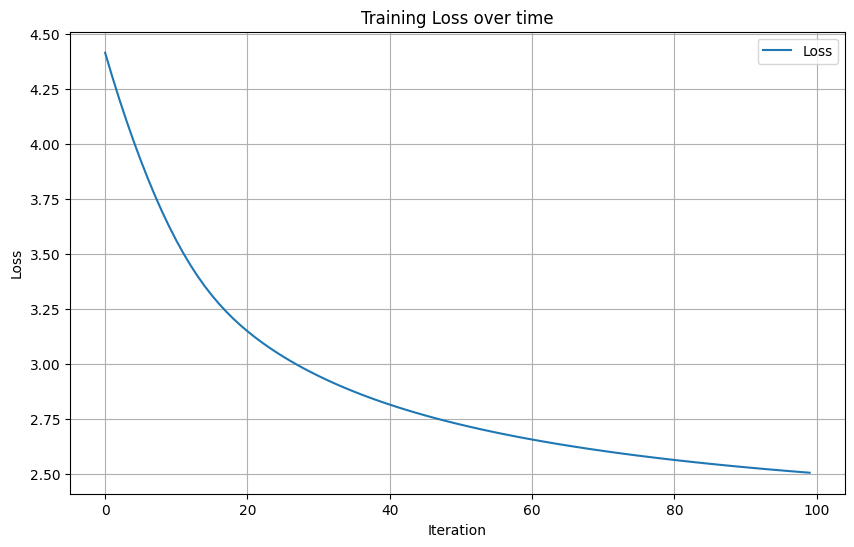

In [9]:
min_loss_storage = min(loss_storage)
plt.figure(figsize=(10, 6))
plt.plot(loss_storage, label="Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss over time")
plt.legend()
plt.grid(True)
plt.show()

In [36]:
class Trigram():
    def __init__(self,
                num_features, 
                num_outputs, 
                num_epochs, 
                learning_rate = 0.01,
                logging=False,
                regularize=False, 
                reg_smooth_strength=None, 
                seed=2147483647,
                enable_tqdm = True,
                *args,
                **kwargs):

       
        self.num_features = num_features
        self.num_outputs = num_outputs
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.regularize = regularize
        self.reg_smooth_strength = reg_smooth_strength
        
        self.enable_tqdm = enable_tqdm

        self.seed = seed
        self.g = torch.Generator().manual_seed(self.seed)
        self.weights = torch.randn((self.num_features, self.num_outputs), generator=self.g)
        self.weights.requires_grad = True

        print("Initialized weights shape: ", self.weights.shape)




    def __call__(self, x, y):
        """This is where we will compute the loss and store it"""

        xenc = F.one_hot(x,  num_classes = self.num_outputs).float().reshape(x.shape[0], -1)
        
        #can also write W with 
        #W = torch.randn(self.num_features, 27), generator = g, requires_grad = True) 
        #print('trigram shape: ', x.shape)
        #print('Encoding shape: ', xenc.shape)
        #print("Weights shape: ", self.weights.shape)

        #This assert statements makes sure downstream dot product can happen
        assert xenc.shape[1] == self.weights.shape[0], "Check weights dimensions" #- failure
        
        logits = (xenc@self.weights) #This calculates neural network output

        #needs to transform logits to positive and then scale 
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims = True) #double check that we keep keepdims = True!

        loss = -probs[torch.arange(x.shape[0]), y].log().mean()

        return loss

    def fit(self, x, y):
        loss_per_iter = []

        epoch_counter = tqdm(range(self.num_epochs)) if self.enable_tqdm else range(self.num_epochs)

        for epoch in epoch_counter:
            #Here we are calling __call__
            loss = self(x,y) 
            
            #Regularization attempt
            if self.regularize:
                loss += self.reg_smooth_strength * (self.weights**2).mean()
            else:
                pass

            self.weights.grad = None #reset the gradient for the weght matrix
            loss.backward() #do back propagation

            if epoch %10 == 0:
                print(f"Loss kth-iter {epoch + 1}: ", loss.item())
            
            loss_per_iter.append(loss.item())

            self.weights.data += -self.learning_rate *self.weights.grad #we want to use a negative value here as we continue to minimize the loss
        
        return loss_per_iter

    def makemore_samples(self, num_examples, itos):
        out = []
        for i in range(num_examples):
            out = []
            to_gen = [0,0]

            while True:
                xenc = F.one_hot(torch.tensor([to_gen]), num_classes = self.num_outputs).float().reshape(1, -1)
                logits = xenc@self.weights
                counts = logits.exp()
                probs = counts/counts.sum(1, keepdims = True)

                pred_input = torch.multinomial(probs, num_samples = 1, replacement = True, generator=self.g).item()

                to_gen = to_gen[1:] + [pred_input]
                new_char = itos[pred_input]
                out.append(new_char)

                if pred_input == 0:
                    break

            print(''.join(out))

In [37]:
words = open('./names.txt','r').read().splitlines()
all_chars = []
for w in words:
    all_chars += list(set(w))


#Alternative
# sorted(list(set(''.join(words)))) #alphabetical listing of all characters in the words
all_chars = list(set(all_chars))

stoi = {char:num for char, num in zip(sorted(all_chars), range(1, len(all_chars)+1))}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}

In [38]:
#Create bigram training set
xs = []
ys = []

for w in words:
    chs = ['.'] + list(w) + ['.'] #adding start and end token to the word character
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        #print(f'Ch1: ', ch1)
        #print(f'Ch2: ', ch2)
        #print(f'Ch3: ', ch3)
        ix1 = stoi.get(ch1, 'ix1 missing')
        ix2 = stoi.get(ch2, 'ix2 missing')
        ix3 = stoi.get(ch3, 'ix3 missing')

        #print('-----')
        xs.append((ix1, ix2))
        ys.append(ix3)


xs = torch.tensor(xs)
ys = torch.tensor(ys)

xs.shape

torch.Size([196113, 2])

In [39]:
##Initiate the trigram model
run_trigram = Trigram(num_features = 54,
                    num_outputs = 27,
                    num_epochs = 50,
                    learning_rate = 1,
                    reg_smooth_strength=0.01,
                    regularize=True,
                    seed = 2147483647)

Initialized weights shape:  torch.Size([54, 27])


  4%|▍         | 2/50 [00:00<00:18,  2.59it/s]

Loss kth-iter 1:  4.195971965789795


 24%|██▍       | 12/50 [00:02<00:05,  7.54it/s]

Loss kth-iter 11:  3.999877452850342


 44%|████▍     | 22/50 [00:03<00:03,  8.84it/s]

Loss kth-iter 21:  3.8271632194519043


 64%|██████▍   | 32/50 [00:04<00:02,  8.32it/s]

Loss kth-iter 31:  3.676630973815918


 84%|████████▍ | 42/50 [00:05<00:00,  8.74it/s]

Loss kth-iter 41:  3.5472300052642822


100%|██████████| 50/50 [00:06<00:00,  7.27it/s]


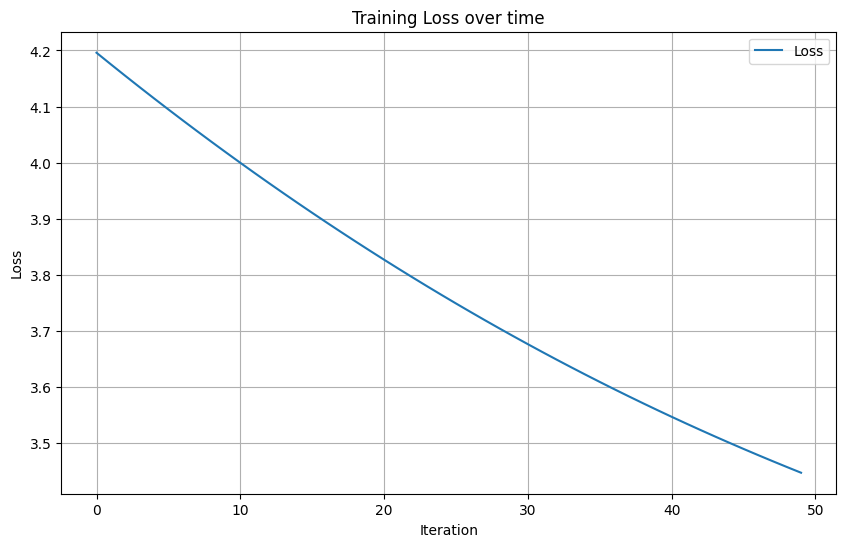

In [40]:
losses = run_trigram.fit(xs, ys)

min_loss_storage = min(losses)
plt.figure(figsize=(10, 6))
plt.plot(losses, label="Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss over time")
plt.legend()
plt.grid(True)
plt.show()

In [41]:
run_trigram.makemore_samples(num_examples=30, itos = itos)

owo.
anfmiesjldpiaitainnh.
ziiahptr.
an.
hpgxqshcdhk.
yogvkbdkzta.
zobgelkyspwxtqwlnu.
bxongbdvgbduncdfkcnbjmuthsaiiavym.
cochvxyedvpumyyftbdqaypgfmfy.
yahpgierxpwocfvpglkbdvlenadsduus.
aanr.
aenewtmk.
oemkavpoxkaiaqalziiu.
n.
voonaochlvlmybdujyigemcgjxqa.
nypgroogdppmcrhmydhvshakoxgjllo.
n.
.
eresdljpghfiupfydtawdzrpbxtanjpkxtstzxyetdgjkjxqfspwgduiiia.
tadllpusfmyftygilvumyrnaaenjbs.
aadxwwlxqxpjdospgadxvwbxqnywwd.
zxsjibdbjfbjkbdhjxxshusztaddpgcs.
.
kodzi.
tziiaiench.
ta.
nr.
gfnvabjxatan.
aemtansplvymyddvaiyqwwetdpmarrzwrt.
aennhmwbdkdhusni.


### Lets run this with a separated train, test, and val split

In [42]:
def split_data(ls_of_words, train_size, test_size ):

    new_list = ls_of_words.copy() 

    random.shuffle(new_list)

    train_len = int(train_size * len(new_list))
    test_len = int(test_size * len(new_list))
    val_len = (len(new_list) - (train_size + test_size)) * len(new_list)

    train_data = new_list[:train_len]
    test_data = new_list[train_len:train_len + test_len]

    val_data = new_list[train_len + test_len:]

    return train_data, test_data, val_data
    
def prepare_datasets(dataset):
    Xtrigram = []
    Ytrigram = []

    for word in dataset:
        chars = ["."] + list(word) + ["."]

        for ch1, ch2, ch3 in zip(chars, chars[1:], chars[2:]):
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            ix3 = stoi[ch3]

            Xtrigram.append((ix1, ix2))
            Ytrigram.append(ix3)

    Xtrigram = torch.tensor(Xtrigram)
    Ytrigram = torch.tensor(Ytrigram)

    return Xtrigram, Ytrigram


In [43]:
train_data, test_data, val_data = split_data(ls_of_words = words,
                                            train_size =0.8,
                                            test_size = 0.1)
print(f"Size of train data, {len(train_data)}")
print(f"Size of test data, {len(test_data)}")
print(f"Size of val data, {len(val_data)}")

print(f"Last word entry in test: {test_data[-1]}")
print(f"First word entry in val: {val_data[0]}")

assert test_data[-1] != val_data[0], "ValueError: Splitting failure for the data. Overlapping entries detected"

Size of train data, 25626
Size of test data, 3203
Size of val data, 3204
Last word entry in test: kennedy
First word entry in val: meryk


In [44]:
X_trigram_train, Y_trigram_train = prepare_datasets(train_data)
X_trigram_test, Y_trigram_test = prepare_datasets(test_data)
X_trigram_val, Y_trigram_val = prepare_datasets(val_data)

Initialized weights shape:  torch.Size([54, 27])


  6%|▌         | 3/50 [00:00<00:06,  7.63it/s]

Loss kth-iter 1:  4.194843292236328


 26%|██▌       | 13/50 [00:01<00:03, 10.80it/s]

Loss kth-iter 11:  3.998065948486328


 46%|████▌     | 23/50 [00:02<00:02, 10.06it/s]

Loss kth-iter 21:  3.8248074054718018


 64%|██████▍   | 32/50 [00:04<00:02,  7.16it/s]

Loss kth-iter 31:  3.6738665103912354


 84%|████████▍ | 42/50 [00:05<00:00,  8.91it/s]

Loss kth-iter 41:  3.5441830158233643


100%|██████████| 50/50 [00:06<00:00,  8.16it/s]


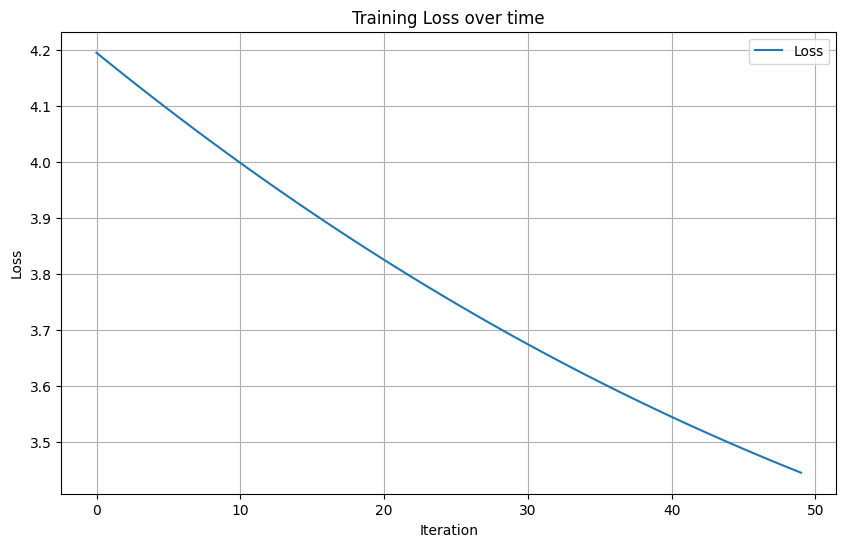

In [45]:
##Initiate the trigram model
run_trigram = Trigram(num_features = 54,
                    num_outputs = 27,
                    num_epochs = 50,
                    learning_rate = 1,
                    reg_smooth_strength=0.01,
                    regularize=True,
                    seed = 2147483647)

losses = run_trigram.fit(X_trigram_train, Y_trigram_train)

min_loss_storage = min(losses)
plt.figure(figsize=(10, 6))
plt.plot(losses, label="Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss over time")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
min(losses)

3.4455196857452393

In [47]:
test_losses = run_trigram(X_trigram_test, Y_trigram_test)

print(test_losses.item())
#print(f"Minimum loss found in test set for trigram model: {min(test_losses)}")


val_losses = run_trigram(X_trigram_val, Y_trigram_val)
print(val_losses.item())
#print(f"Minimum loss found in val set for trigram model: {min(test_losses)}")

3.445789337158203
3.4300789833068848


All of the trigram datasets are pretty similar. So the training data is doing a decent job of capturing a representative sample of the available trigrams. However loss isn't great.


### Exercise 3

 use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

In [48]:
##Supporting plotting with 2d

def plot_smooth_scores(smooth_scores):
    """
    Plots training loss over time for each smoothing value.

    Parameters:
    smooth_scores (dict): Dictionary with smoothing values as keys (e.g., '0.01') and lists of loss values as values.

    Returns:
    None
    """
    plt.figure(figsize=(10, 6))
    
    for smoothing_value, losses in smooth_scores.items():
        # Plot each smoothing value's loss with a unique label and color
        plt.plot(losses, label=f"Smoothing {smoothing_value}")
    
    # Labels and title
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time for Different Smoothing Values")
    plt.legend(title="Smoothing Values")
    plt.grid(True)
    plt.show()

This is the smoothing value: 0.0
Initialized weights shape:  torch.Size([54, 27])


  2%|▏         | 1/50 [00:00<00:05,  9.40it/s]

Loss kth-iter 1:  4.189068794250488


 24%|██▍       | 12/50 [00:00<00:00, 61.70it/s]

Loss kth-iter 11:  3.9922494888305664


 44%|████▍     | 22/50 [00:00<00:00, 71.37it/s]

Loss kth-iter 21:  3.818662405014038


 60%|██████    | 30/50 [00:00<00:00, 70.50it/s]

Loss kth-iter 31:  3.6672844886779785


 76%|███████▌  | 38/50 [00:00<00:00, 72.41it/s]

Loss kth-iter 41:  3.537203550338745


100%|██████████| 50/50 [00:00<00:00, 69.50it/s]


This is the smoothing value: 0.019999999552965164
Initialized weights shape:  torch.Size([54, 27])


  4%|▍         | 2/50 [00:00<00:03, 15.52it/s]

Loss kth-iter 1:  4.208469390869141


 16%|█▌        | 8/50 [00:00<00:01, 38.37it/s]

Loss kth-iter 11:  4.010797023773193


 44%|████▍     | 22/50 [00:00<00:00, 50.15it/s]

Loss kth-iter 21:  3.8365139961242676


 86%|████████▌ | 43/50 [00:00<00:00, 59.54it/s]

Loss kth-iter 31:  3.684567451477051
Loss kth-iter 41:  3.554018020629883


100%|██████████| 50/50 [00:01<00:00, 41.44it/s]


This is the smoothing value: 0.03999999910593033
Initialized weights shape:  torch.Size([54, 27])


 12%|█▏        | 6/50 [00:00<00:00, 57.01it/s]

Loss kth-iter 1:  4.227870464324951
Loss kth-iter 11:  4.029323577880859


 60%|██████    | 30/50 [00:00<00:00, 66.31it/s]

Loss kth-iter 21:  3.854325532913208
Loss kth-iter 31:  3.7017924785614014


100%|██████████| 50/50 [00:00<00:00, 65.33it/s]


Loss kth-iter 41:  3.570756435394287
This is the smoothing value: 0.05999999865889549
Initialized weights shape:  torch.Size([54, 27])


  0%|          | 0/50 [00:00<?, ?it/s]

Loss kth-iter 1:  4.2472710609436035


 18%|█▊        | 9/50 [00:00<00:00, 83.27it/s]

Loss kth-iter 11:  4.047829627990723


 54%|█████▍    | 27/50 [00:00<00:00, 34.00it/s]

Loss kth-iter 21:  3.8720972537994385
Loss kth-iter 31:  3.718958854675293


100%|██████████| 50/50 [00:00<00:00, 54.67it/s]


Loss kth-iter 41:  3.587418556213379
This is the smoothing value: 0.07999999821186066
Initialized weights shape:  torch.Size([54, 27])


 20%|██        | 10/50 [00:00<00:00, 94.54it/s]

Loss kth-iter 1:  4.266672134399414
Loss kth-iter 11:  4.066315650939941


 40%|████      | 20/50 [00:00<00:00, 85.74it/s]

Loss kth-iter 21:  3.88982892036438


 58%|█████▊    | 29/50 [00:00<00:00, 83.75it/s]

Loss kth-iter 31:  3.7360661029815674


100%|██████████| 50/50 [00:00<00:00, 88.88it/s]


Loss kth-iter 41:  3.6040046215057373
This is the smoothing value: 0.10000000149011612
Initialized weights shape:  torch.Size([54, 27])


 18%|█▊        | 9/50 [00:00<00:00, 88.69it/s]

Loss kth-iter 1:  4.286072731018066


 38%|███▊      | 19/50 [00:00<00:00, 92.28it/s]

Loss kth-iter 11:  4.084779739379883
Loss kth-iter 21:  3.907520294189453


 76%|███████▌  | 38/50 [00:00<00:00, 85.64it/s]

Loss kth-iter 31:  3.753115653991699


 94%|█████████▍| 47/50 [00:00<00:00, 86.92it/s]

Loss kth-iter 41:  3.6205155849456787


100%|██████████| 50/50 [00:00<00:00, 85.60it/s]


This is the smoothing value: 0.11999999731779099
Initialized weights shape:  torch.Size([54, 27])


  0%|          | 0/50 [00:00<?, ?it/s]

Loss kth-iter 1:  4.305473804473877


 16%|█▌        | 8/50 [00:00<00:00, 75.42it/s]

Loss kth-iter 11:  4.103224754333496


 32%|███▏      | 16/50 [00:00<00:00, 62.24it/s]

Loss kth-iter 21:  3.9251720905303955


 62%|██████▏   | 31/50 [00:00<00:00, 61.19it/s]

Loss kth-iter 31:  3.770106792449951


 80%|████████  | 40/50 [00:00<00:00, 69.91it/s]

Loss kth-iter 41:  3.636950969696045


100%|██████████| 50/50 [00:00<00:00, 67.40it/s]


This is the smoothing value: 0.14000000059604645
Initialized weights shape:  torch.Size([54, 27])


  0%|          | 0/50 [00:00<?, ?it/s]

Loss kth-iter 1:  4.324874401092529


 14%|█▍        | 7/50 [00:00<00:00, 65.88it/s]

Loss kth-iter 11:  4.12164831161499


 46%|████▌     | 23/50 [00:00<00:00, 70.39it/s]

Loss kth-iter 21:  3.942783832550049


 64%|██████▍   | 32/50 [00:00<00:00, 75.56it/s]

Loss kth-iter 31:  3.7870407104492188


 80%|████████  | 40/50 [00:00<00:00, 75.51it/s]

Loss kth-iter 41:  3.653311014175415


100%|██████████| 50/50 [00:00<00:00, 71.10it/s]


This is the smoothing value: 0.1599999964237213
Initialized weights shape:  torch.Size([54, 27])


  0%|          | 0/50 [00:00<?, ?it/s]

Loss kth-iter 1:  4.34427547454834


 60%|██████    | 30/50 [00:00<00:00, 57.98it/s]

Loss kth-iter 11:  4.14005184173584
Loss kth-iter 21:  3.9603562355041504
Loss kth-iter 31:  3.8039164543151855


100%|██████████| 50/50 [00:00<00:00, 52.36it/s]


Loss kth-iter 41:  3.6695966720581055
This is the smoothing value: 0.18000000715255737
Initialized weights shape:  torch.Size([54, 27])


  0%|          | 0/50 [00:00<?, ?it/s]

Loss kth-iter 1:  4.363676071166992


 18%|█▊        | 9/50 [00:00<00:00, 82.72it/s]

Loss kth-iter 11:  4.1584343910217285


 54%|█████▍    | 27/50 [00:00<00:00, 77.36it/s]

Loss kth-iter 21:  3.977888822555542


 72%|███████▏  | 36/50 [00:00<00:00, 79.60it/s]

Loss kth-iter 31:  3.8207345008850098


 88%|████████▊ | 44/50 [00:00<00:00, 75.16it/s]

Loss kth-iter 41:  3.685807704925537


100%|██████████| 50/50 [00:00<00:00, 74.03it/s]


This is the smoothing value: 0.20000000298023224
Initialized weights shape:  torch.Size([54, 27])


  0%|          | 0/50 [00:00<?, ?it/s]

Loss kth-iter 1:  4.383077144622803


 12%|█▏        | 6/50 [00:00<00:00, 59.04it/s]

Loss kth-iter 11:  4.1767964363098145


 50%|█████     | 25/50 [00:00<00:00, 83.47it/s]

Loss kth-iter 21:  3.9953815937042236
Loss kth-iter 31:  3.8374955654144287


100%|██████████| 50/50 [00:00<00:00, 81.16it/s]


Loss kth-iter 41:  3.70194411277771
This is the smoothing value: 0.2199999988079071
Initialized weights shape:  torch.Size([54, 27])


 20%|██        | 10/50 [00:00<00:00, 96.55it/s]

Loss kth-iter 1:  4.402477741241455
Loss kth-iter 11:  4.195137977600098


 60%|██████    | 30/50 [00:00<00:00, 90.01it/s]

Loss kth-iter 21:  4.0128350257873535
Loss kth-iter 31:  3.854198694229126
Loss kth-iter 41:  3.7180063724517822


100%|██████████| 50/50 [00:00<00:00, 94.58it/s]


This is the smoothing value: 0.23999999463558197
Initialized weights shape:  torch.Size([54, 27])


 16%|█▌        | 8/50 [00:00<00:00, 79.26it/s]

Loss kth-iter 1:  4.421878814697266
Loss kth-iter 11:  4.213459491729736


 70%|███████   | 35/50 [00:00<00:00, 83.63it/s]

Loss kth-iter 21:  4.030249118804932
Loss kth-iter 31:  3.870844602584839
Loss kth-iter 41:  3.733994960784912


100%|██████████| 50/50 [00:00<00:00, 74.42it/s]


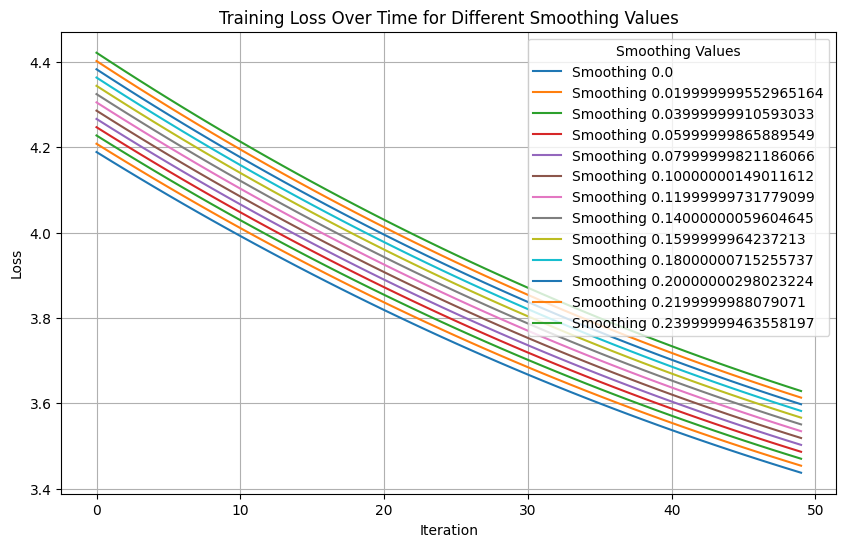

In [51]:
smoothing_scores = {}

for i in torch.arange(0, 0.25, .02):
    ##Initiate the trigram model

    print(f"This is the smoothing value: {i}")

    run_trigram = Trigram(num_features = 54,
                        num_outputs = 27,
                        num_epochs = 50,
                        learning_rate = 1,
                        reg_smooth_strength=i,
                        regularize=True,
                        seed = 2147483647)

    losses = run_trigram.fit(X_trigram_val, Y_trigram_val)
    smoothing_scores[i] = losses


plot_smooth_scores(smooth_scores=smoothing_scores)

Interestingly, it seems that loss that performs the best is zero? 

### Exercise 4:

we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

Yes! Weights can be selected by finding the correct index corresponding to a trigram character combination. It's just a matter of keeping the indices straight. See below. 

`logits = (xenc@self.weights) -> logits = self.weights[x]`




### Exercise 5: 

 look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

In [ ]:
def crossentropy_call(self, x, y):
        """This is where we will compute the loss and store it"""

        xenc = F.one_hot(x,  num_classes = self.num_outputs).float().reshape(x.shape[0], -1)
        
        #can also write W with 
        #W = torch.randn(self.num_features, 27), generator = g, requires_grad = True) 
        #print('trigram shape: ', x.shape)
        #print('Encoding shape: ', xenc.shape)
        #print("Weights shape: ", self.weights.shape)

        #This assert statements makes sure downstream dot product can happen
        assert xenc.shape[1] == self.weights.shape[0], "Check weights dimensions" #- failure
        
        logits = (xenc@self.weights) #This calculates neural network output

        #needs to transform logits to positive and then scale 
        # counts = logits.exp()
        # probs = counts / counts.sum(1, keepdims = True) #double check that we keep keepdims = True!

        # loss = -probs[torch.arange(x.shape[0]), y].log().mean()
        loss = F.cross_entropy(logits, y)

        return loss